https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve

**可以试着学习这篇文章的结构， 完成一篇论文/报告！**

# Credit Card Fraud: Handling highly imbalance classes and why Receiver Operating Characteristics Curve (ROC Curve) should not be used, and Precision/Recall curve should be preferred in highly imbalanced situations

## Motivation
In this notebook, we will explore the data through initial EDA with some visualizations. Then we will hit the main point of the notebook, which is to explore ways to handle imbalanced data. We will use two methods:

* Using the weights parameters in Sci-Kit Learn classifiers
* Over and Undersampling (to be developed in the next version)

Finally, we will quantify and illustrate the effects of the trade off between True Positive Rate and False Positive Rate using ROC and Precision/Recall (PR) curves, and disucss why the popular ROC curve should not be used on highly imbalanced dataset (or in general, why I prefer PR curves over ROC).

In [25]:
import pandas as pd
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200
import numpy as np

import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve

import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

## Imports and reading in the data

In [2]:
df = pd.read_csv('data_gen/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The data has a column called 'Time', which are seconds from which the very first data observation took place. Let's convert that to hours of a day. I'm guessing the data starts at midnight and ends at midnight.

In [7]:
df.shape

(284807, 32)

In [10]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
df['Time'].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

In [3]:
df['hour'] = df['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)

Seems right that we have the least transactions from 1AM to 5AM. Let's see a breakdown of our legit vs fraud transactions via a pivot table.

Note:

* Class 0 = Legit transactions
* Class 1 = Fruadulent transactions

In [5]:
df.pivot_table(values='Amount',index='hour',columns='Class',aggfunc='count')

Class,0,1
hour,,
0.0,10919,21
1.0,7687,6
2.0,4212,10
3.0,3269,57
4.0,3476,17
5.0,2185,23
6.0,2979,11
7.0,4093,9
8.0,7219,23


## Visualizing the data

In [8]:
def PlotHistogram(df,norm):
    bins = np.arange(df['hour'].min(),df['hour'].max()+2)
    plt.figure(figsize=(15,4))
    sns.distplot(df[df['Class']==0.0]['hour'],
                 norm_hist=norm,
                 bins=bins,
                 kde=False,
                 color='b',
                 hist_kws={'alpha':.5},
                 label='Legit')
    sns.distplot(df[df['Class']==1.0]['hour'],
                 norm_hist=norm,
                 bins=bins,
                 kde=False,
                 color='r',
                 label='Fraud',
                 hist_kws={'alpha':.5})
    plt.xticks(range(0,24))
    plt.legend()
    plt.show()

Normalized histogram of Legit/Fraud over hour of the day


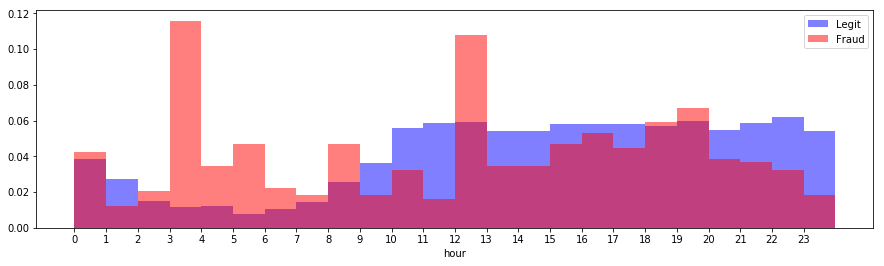

Counts histogram of Legit/Fraud over hour of the day
*you can barely see the Fraud cases since there are so little of them.


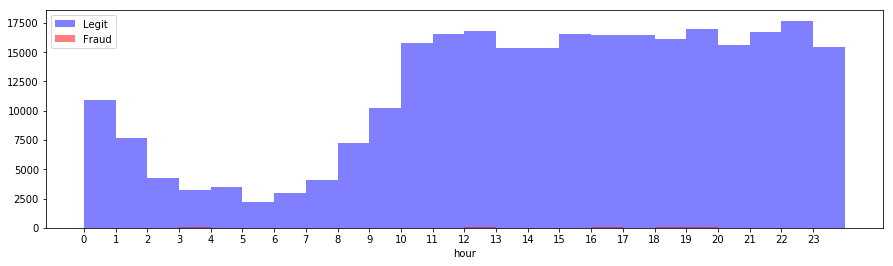

0.8341109752655029


In [9]:
start = time.time()
print('Normalized histogram of Legit/Fraud over hour of the day')
PlotHistogram(df,True)
print('Counts histogram of Legit/Fraud over hour of the day')
print('*you can barely see the Fraud cases since there are so little of them.')
PlotHistogram(df,False)
print(time.time()-start)

In [11]:
print('Fraud is {}% of our data.'.format(df['Class'].value_counts()[1] / float(df['Class'].value_counts()[0])*100))

Fraud is 0.17304750013189596% of our data.


Hour of the day seems to have some impact on the number of Fraud cases. I'll be sure to to add the 'hour' dimension to visualizations later to further investigate its impact.

Before we train our classifers, we need to normalize the Amount since it's on a totally different scale. The distributions are also highly skewed with a lot of statistical outliers. All Fraud cases are in the low dollar values i.e. Amount.

We also have a HUGE class imbalance. More on that later when we start to train classifiers.

In [12]:
mask_true = (df['Class'] == 1.0) 
mask_false = (df['Class'] == 0.0)

df['Amount'] = StandardScaler().fit_transform(df[['Amount']])

In [13]:
df['Amount'].describe()

count    2.848070e+05
mean     3.202236e-16
std      1.000002e+00
min     -3.532294e-01
25%     -3.308401e-01
50%     -2.652715e-01
75%     -4.471707e-02
max      1.023622e+02
Name: Amount, dtype: float64

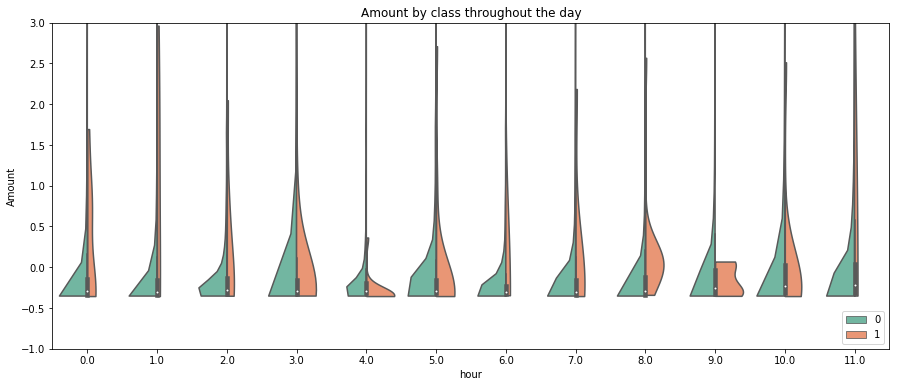

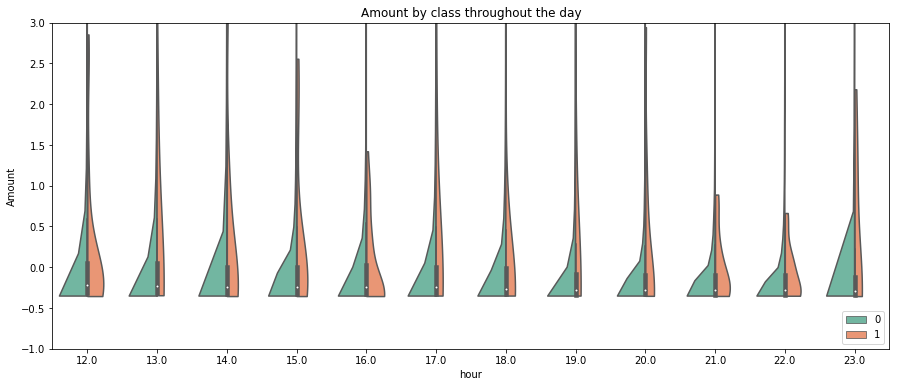

In [14]:
def PlotViolins(minHour,maxHour):
    plt.figure(figsize=(15,6))
    plt.title('Amount by class throughout the day')
    plt.ylim([-1,3.0])
    sns.violinplot(data=df[df['hour'].isin(range(minHour,maxHour+1))],x='hour',y='Amount',hue='Class',split=True,palette='Set2',cut=0)
    plt.legend(loc='lower right')
    plt.show()
PlotViolins(0,11)
PlotViolins(12,23)

Let's see how well the PCA components complement each other by looking their interactions with each other. I'm only including the first 6 components here.

Seems like most features show both Fraud and Legit purchases overlapping each other, with V4 showing a little promise. We can't rely on our eyes to do all the investigation work since we at most can make 4-dimensional charts (3 features + a color) to investigate our data, and our data has more than 30 features.

Let's get to model building and see how well our data can separate the classes.

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


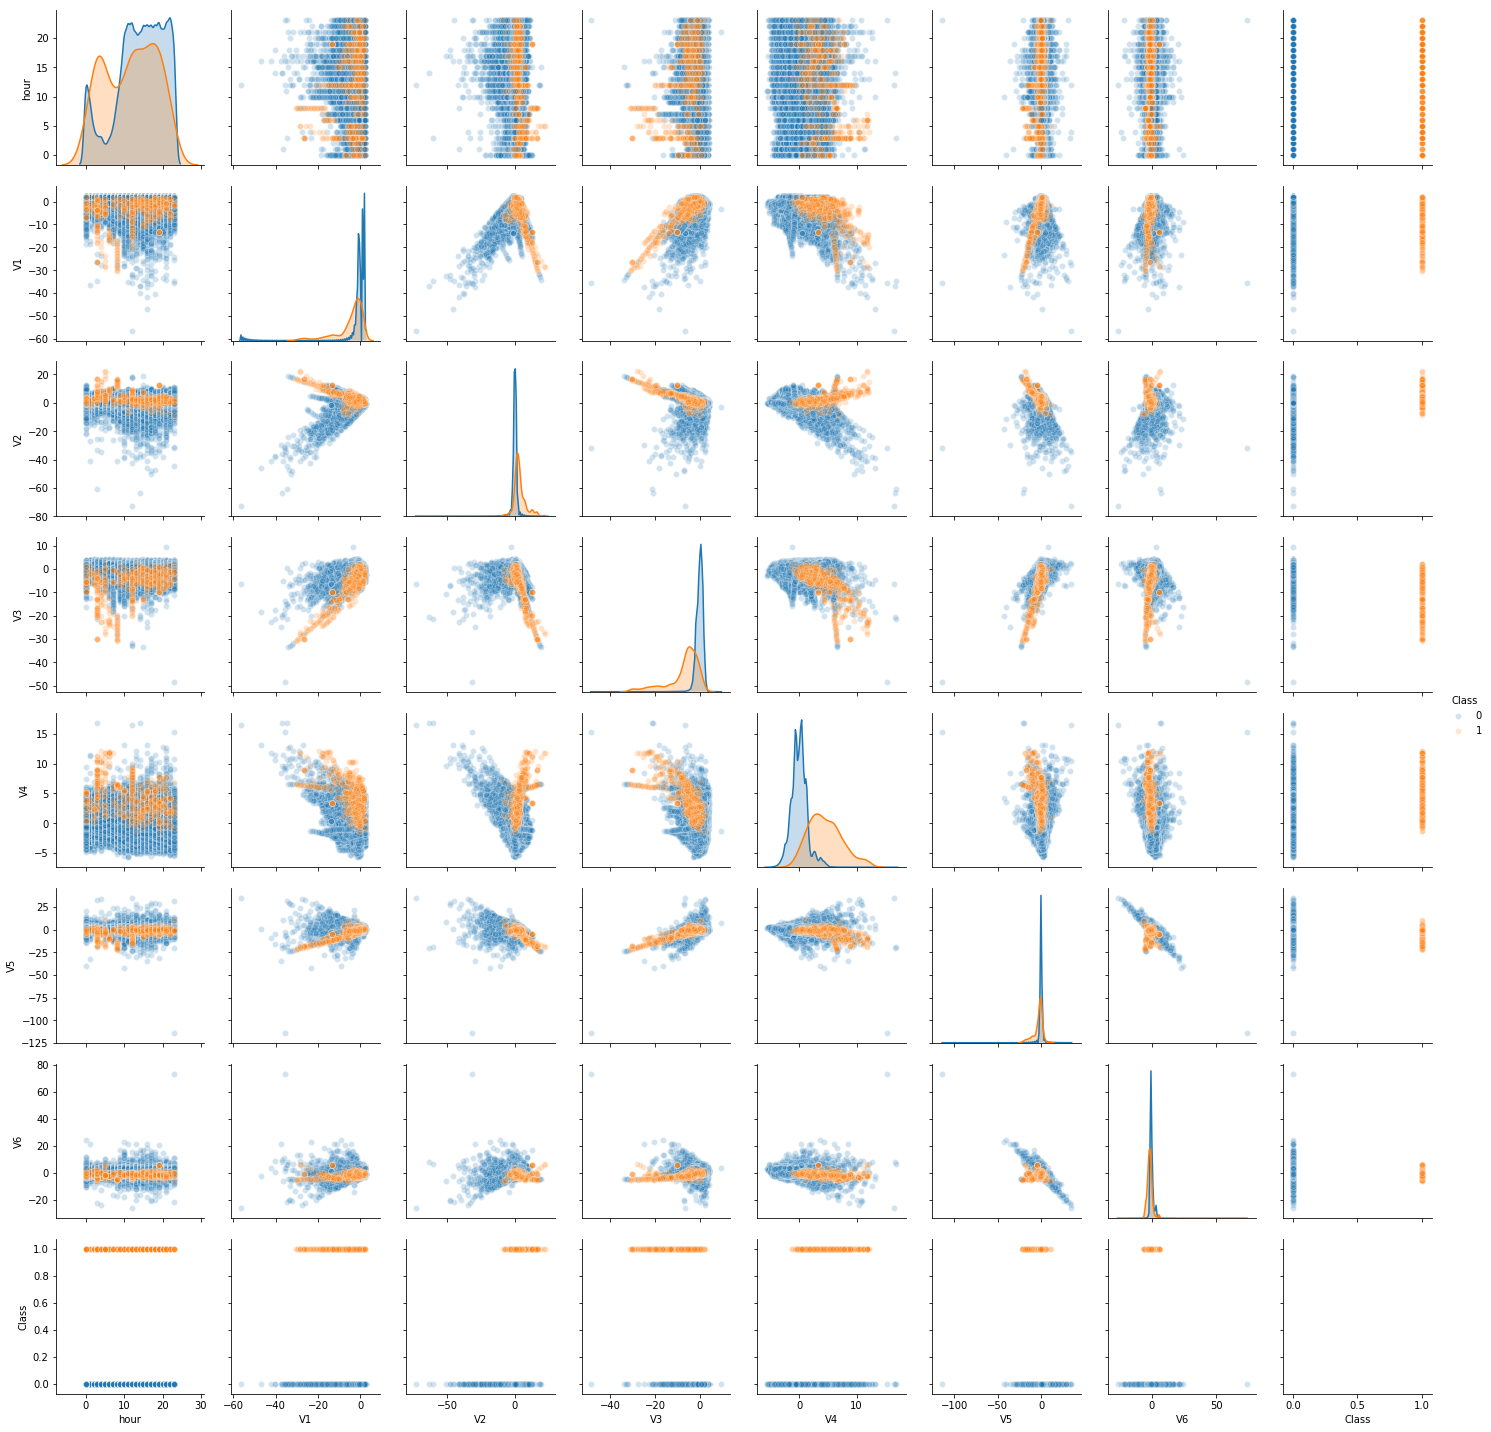

In [15]:
sns.pairplot(data=pd.concat([df.loc[:,'hour'],df.loc[:,'V1':'V6'],df.loc[:,'Class']],axis=1),
             hue='Class',
             diag_kind='kde',
             plot_kws={'alpha':0.2})

## Model building
Let's start with a vanilla Logistic Regression since it seems like for some of the features, a sigmoid curve can sort of separate the classes.

In [16]:
features = pd.concat([df.loc[:,'V1':'Amount'],df.loc[:,'Time']],axis=1)
target = df['Class']

x_train,x_test,y_train,y_test = train_test_split(features,target, stratify=target,test_size=0.35, random_state=1)

print('y_train class counts')
print(y_train.value_counts())
print('')
print('y_test class counts')
print(y_test.value_counts())

y_train class counts
0    184804
1       320
Name: Class, dtype: int64

y_test class counts
0    99511
1      172
Name: Class, dtype: int64


In [18]:
# Let's store our y_test legit and fraud counts for normalization purposes later on
y_test_legit = y_test.value_counts()[0]
y_test_fraud = y_test.value_counts()[1]

In [19]:
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)

pred = lr_model.predict(x_test)

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
def PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud):

    cfn_matrix = confusion_matrix(y_test,pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

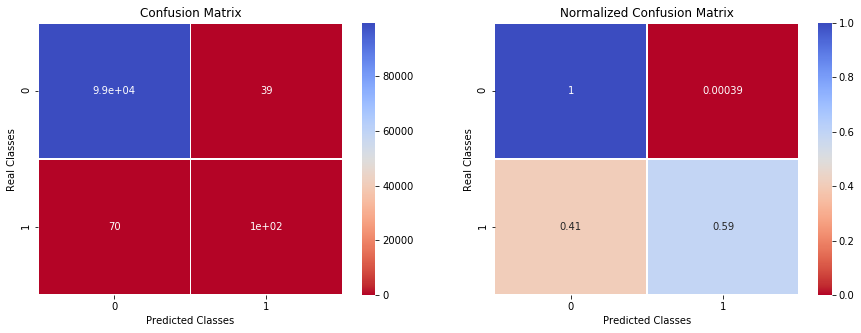

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.72      0.59      0.65       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.86      0.80      0.83     99683
weighted avg       1.00      1.00      1.00     99683



In [21]:
PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud)

I'm not a huge fan of confusion matrix because they can be misleading. I almost ALWAYS go directly to my classification report for precision and recall scores for each class. **And Seaborn's heatmap coloring scheme is not helping**. Our True Positive rate is 0.59 as also shown in the classification report which is not TOO bad, but it's shown as blood red. The normalized confusion matrix tells a better story. But, actual precision and recall scores are my go-to metrics.

It seems like we aren't very good with catching our frauds, which is expected with a vanilla Logistic Regression without addressing the class imbalance issue.

## Addressing class imbalance
### Using weights to counteract the class imbalance
Sci-Kit Learn classifiers can give heavier weights to the minority class using a simple parameter during model initiation. Let's see how that will improve our results

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


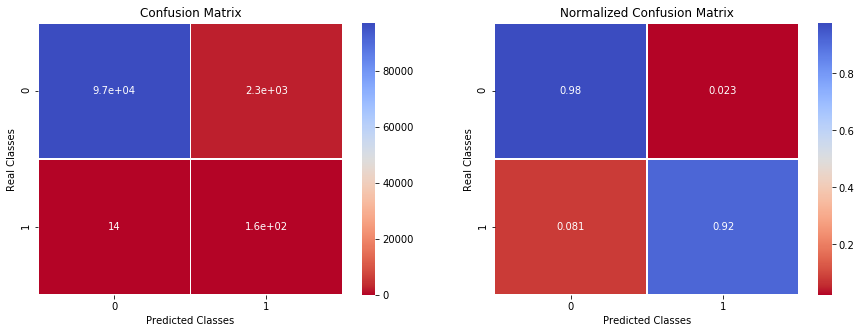

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     99511
           1       0.06      0.92      0.12       172

   micro avg       0.98      0.98      0.98     99683
   macro avg       0.53      0.95      0.55     99683
weighted avg       1.00      0.98      0.99     99683



In [22]:
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(x_train,y_train)

pred = lr_model.predict(x_test)

PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud)

Looking at the normalized confusion matrix, it seems like our classifer is doing very well! We have a 98% True Negative rate and a 92% True Positive rate! Seems like a perfect classifer, doesn't it?

However, if we look at the individual precision scores, this classifer is now a lot less precise than before. This is because we have increased our Fraud recall score at the expense of more mis-classified Legit cases. With the "balanced" weight parameter, we have increased our false positive counts from 39 to 2300. 2300 is still only a small fraction of truely negative cases (out of 99511), that's why the percentage shown on the Normalized Confusion Matrix is still relatively small at 0.023%. 

Let's try to specify our own weights. The weights are somewhat arbitrary but it illustrates the tradeoff between precision and recall.

---Weight of 1 for Fraud class---


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


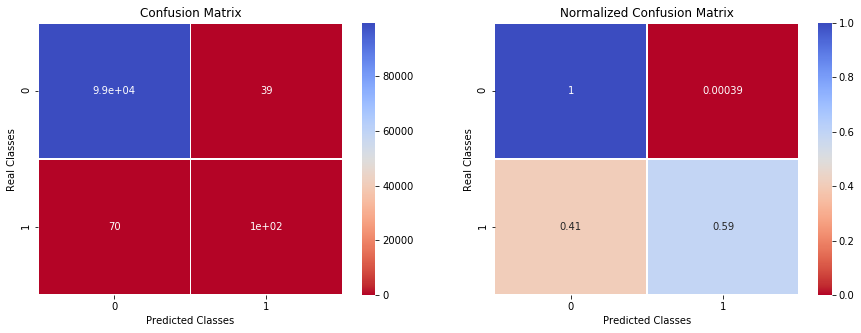

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.72      0.59      0.65       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.86      0.80      0.83     99683
weighted avg       1.00      1.00      1.00     99683

---Weight of 5 for Fraud class---


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


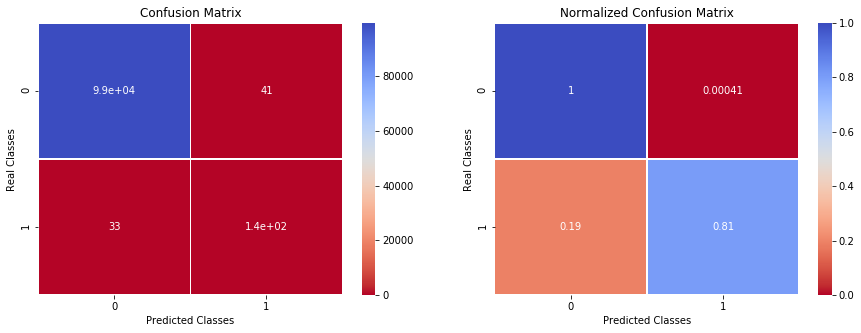

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.77      0.81      0.79       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.89      0.90      0.89     99683
weighted avg       1.00      1.00      1.00     99683

---Weight of 10 for Fraud class---


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


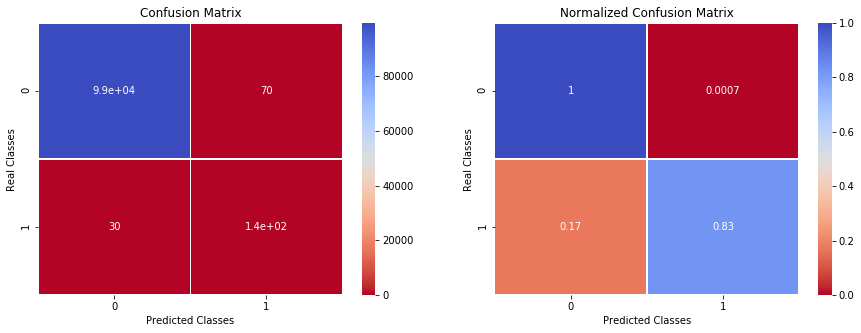

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.67      0.83      0.74       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.83      0.91      0.87     99683
weighted avg       1.00      1.00      1.00     99683

---Weight of 100 for Fraud class---


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


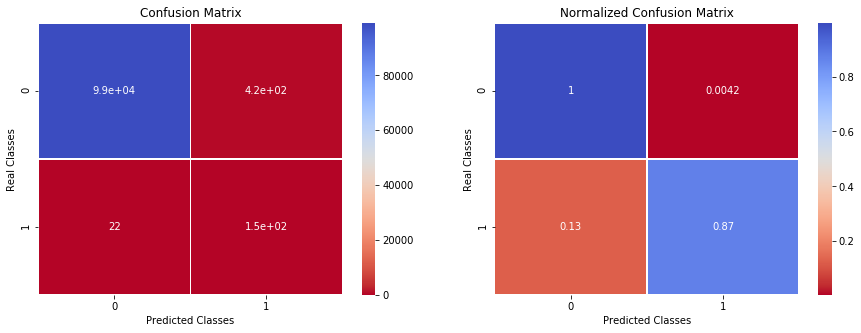

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.26      0.87      0.40       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.63      0.93      0.70     99683
weighted avg       1.00      1.00      1.00     99683

---Weight of 500 for Fraud class---


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


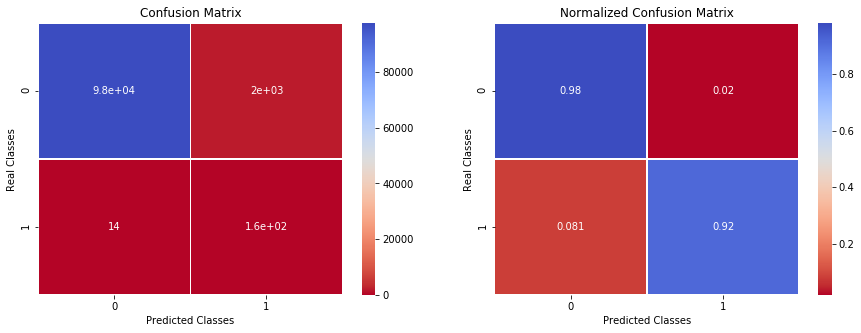

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     99511
           1       0.07      0.92      0.14       172

   micro avg       0.98      0.98      0.98     99683
   macro avg       0.54      0.95      0.56     99683
weighted avg       1.00      0.98      0.99     99683

---Weight of 1000 for Fraud class---


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


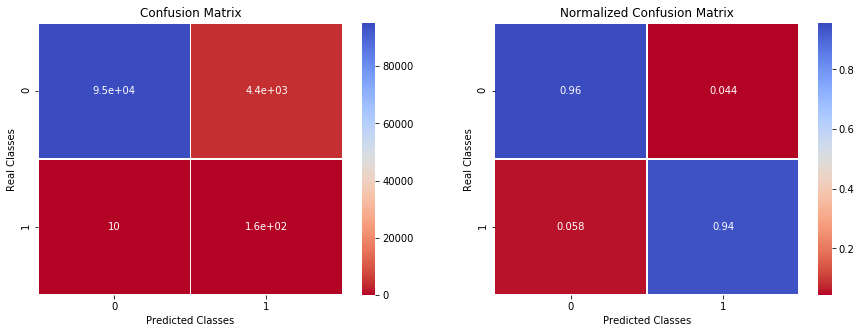

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     99511
           1       0.04      0.94      0.07       172

   micro avg       0.96      0.96      0.96     99683
   macro avg       0.52      0.95      0.52     99683
weighted avg       1.00      0.96      0.98     99683



In [23]:
for w in [1,5,10,100,500,1000]:
    print('---Weight of {} for Fraud class---'.format(w))
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(x_train,y_train)

    pred = lr_model.predict(x_test)
    PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud)

## ROC versus Precision/Recall Curves
Just by manaually selecting a range of weights to boost the minority class already helped our model have better recall, and in some cases, better precision also. Recall and Precision are usually trade offs of each other, so when you can improve both at the same time, your model's overall performance is undeniably improved.

To illustrate the trade off between precision vs recall, and let's also include False Positive Rate vs True Positive Rate (ROC), let's plot the ROC and Precision/Recall curves for different weights for the minority class.

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver 

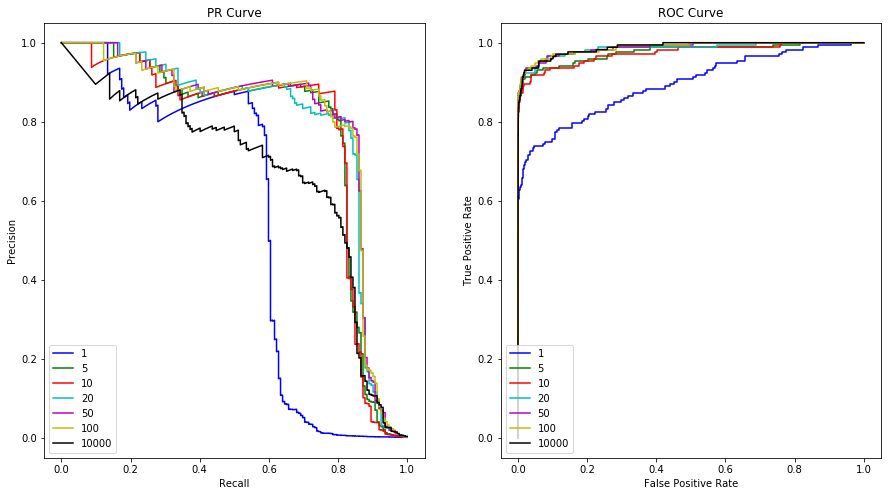

In [24]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1,5,10,20,50,100,10000],'bgrcmykw'):
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(x_train,y_train)
    pred_prob = lr_model.predict_proba(x_test)[:,1]

    p,r,_ = precision_recall_curve(y_test,pred_prob)
    tpr,fpr,_ = roc_curve(y_test,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()

## Conclusion
For a PR curve, a good classifer aims for the upper right corner of the chart but upper left for the ROC curve.

While PR and ROC curves use the same data, i.e. the real class labels and predicted probability for the class lables, you can see that the two charts tell very different stories, with some weights seem to perform better in ROC than in the PR curve.

While the blue, w=1, line performed poorly in both charts, the black, w=10000, line performed "well" in the ROC but poorly in the PR curve. This is due to the high class imbalance in our data. ROC curve is not a good visual illustration for highly imbalanced data, because the False Positive Rate ( False Positives / Total Real Negatives ) does not drop drastically when the Total Real Negatives is huge.

Whereas Precision ( True Positives / (True Positives + False Positives) ) is highly sensitive to False Positives and is not impacted by a large total real negative denominator.

The biggest difference among the models are at around 0.8 recall rate. Seems like a lower weight, i.e. 5 and 10, out performs other weights significantly at 0.8 recall. This means that with those specific weights, our model can detect frauds fairly well (catching 80% of fraud) while not annoying a bunch of customers with false positives with an equally high precision of 80%.

Without further tuning our model, and of course we should do cross validation for any real model tuning/validation, it seems like a vanilla Logistic Regression is stuck at around 0.8 Precision and Recall.

So how do we know if we should sacrifice our precision for more recall, i.e. catching fraud? That is where data science meets your core business parameters. If the cost of missing a fraud highly outweighs the cost of canceling a bunch of legit customer transactions, i.e. false positives, then perhaps we can choose a weight that gives us a higher recall rate. Or maybe catching 80% of fraud is good enough for your business if you can minimize also minimize the "user friction" or credit card disruptions by keeping our precision high.